![Astrofisica Computacional](../../logo.PNG)

---
## 39. Integradores LeapFrog y Verlet. 

Eduard Larrañaga (ealarranaga@unal.edu.co)

---


### Resumen

Se presentan los integradores LeapFrog y Verlet para resolver sistemas de ODEs.

`A. Garcia. Numerical Methods for Physics. (1999). Chapter 3 `

---

## Integrador LeapFrog 

Considere el siguiente sistema de ODEs,

\begin{equation}
\frac{d^2 x}{dt^2} = a(x),
\end{equation}

que puede ser escrito como el sistema diferencial de primer orden

\begin{align}
\begin{cases}
\frac{d x}{dt} = &v \\
\frac{dv}{dt} = & a(x(t)).
\end{cases}
\end{align}


**Note la dependencia de la función $a = a(x(t))$ el el lado derecho de las ecuaciones.**

Discretización de la derivada temporal (utilizando diferencias centradas) en la segunda ecuación da como resultado

\begin{equation}
\frac{v(t+h) - v(t-h)}{2h} + \mathcal{O}(h^2)= a(x(t)).
\end{equation}

En la primera ecuación diferencial también se utilizará una discretización centrada de la derivada, pero en este caso se centrará en el punto $t+h$ (esto quiere decir que allí se utilizaran los puntos $t+2h$ y $t$). Con ello se obtiene

\begin{equation}
\frac{x(t+2h) - x(t)}{2h} + \mathcal{O}(h^2)= v(t+h).
\end{equation}

Estas dos ecuaciones de diferencias se escriben en forma iterativa asi,

\begin{align}
\begin{cases}
\frac{x_{n+2} - x_n}{2h} + \mathcal{O}(h^2) &=  v_{n+1} \\
\frac{v_{n+1} - v_{n-1}}{2h} + \mathcal{O}(h^2) &= a(x_n).
\end{cases}
\end{align}

Re-acomodando estas ecuaciones, se obtiene el método iteratio conocido como **Leap-Frog**,

\begin{align}
\begin{cases}
v_{n+1} &=  v_{n-1} + 2h  a(x_n)  + \mathcal{O}(h^3)\\
x_{n+2} &=  x_n + 2h v_{n+1}  + \mathcal{O}(h^3)
\end{cases}
\end{align}

Este es un método de orden $\mathcal{O}(h^3)$ y su nombre se debe a que la solución se construye con pasos de tamaño $2h$, con la función de posición $x$ avanzando en valores pares, $x_0, x_2, x_4, ...$, mientras que la función velocidad $v$ avanza en valores impares $v_1, v_3, v_5, ...$. 

El origen de este tipo de comportamiento está en la dependencia de la función $a=a(x(t))$, la cual implica que su valor debe ser evaluado en un instante de tiempo centrado entre los valores antiguo y nuevo de la función $v$.

<center>
<img src="https://i.ibb.co/p1Pb63S/Screen-Shot-2021-06-08-at-7-11-33-PM.png" alt="Screen-Shot-2021-06-08-at-7-11-33-PM" border="0"></a>
</center>

El método LeapFrog es computacionalmente mas eficiente que el método Predictor-Corrector  y requiere menos almacenamiento de información. Al ser uno de los algoritmo **simplecticos** (i.e. que preservan el área en el espacio de fase §), la conservación de la energía es respetada, aún con pasos de tiempo grandes.De esta forma, este tipo de algoritmos puede lograr una disminución apreciable en el tiempo de computo. Sin embargo, en algunos casos en los que se requieren valores de posición y velocidad mas precisos, se suelen preferir algoritmos como el Predictor-Corrector o los métodos RK. 


§ Se puede demostrar que el algoritmo Leapfrog preserva las areas encerradas por las trayectorias en el espacio de fase (p vs. x) a lo largo de la evolución del sistema. Esto implica que la energía es conservada durante la evolución.


El sistema de ODEs es implementado mediante una función cuya dependencia es únicamente $f(x(t))$,

In [1]:
import numpy as np

# Newtonian Gravitational Constant
G = 4.*np.pi**2
M = 1.

def ODE(q0):
    '''
    ------------------------------------------
    ODE(q0) 
    ------------------------------------------
    ODEs system for the motion of a comet 
    around the Sun using cartesian coordinates
    in the orbital plane.
    ------------------------------------------
    Arguments:
    q0: NumPy array with the coordinates 
        defined as
    q0[0] = x: coordinate x
    q0[1] = y: coordinate y
    ------------------------------------------
    Returns:
    a = NumPy array with the components of the 
        acceleration
    '''
    r2 = q0[0]**2 + q0[1]**2
    a = - G*M*q0[0:2]/r2**(3/2)
    return a


--- 
## Condición Inicial

Para ilustrar la utilización del método LeapFrog se utilizará la condición incial que se estableció al utilizar los métodos de Euler y RK4: 
- La posición inicial será $x_0 = 1 \text{ au}$ y $y_0 = 0 \text{ au}$ 
- La velocidad inicial es $v^x_0=0 \text{ au/yr}$ y $v^y_0 = 3 \text{ au/yr}$.

Se considerará una malla temporal desde $t_0 = 0$ a $t_f = 20$ años con un millón de pasos.


**Nota:** El método Leap-Frog no se *auto-inicia* porque, además de los valores iniciales presentados,$(x_0, y_0)$ $(v^x_0, v^y_0)$, es necesario conocer  los valores $(v^x_{-1}, v^y_{-1})$. Una de las posibilidades para inciar el algoritmo es realizar un paso de Euler hacia atrás para obtener la información requerida,
\begin{align}
v^x_{-1} = &v^x_0 - h a^x(x_0,y_0) \\
v^y_{-1} = &v^y_0 - h a^y(x_0,y_0).
\end{align}

## Solucionando el Sistema de ODEs

Se implementa la malla de discretización y el método LeapFrog.

In [2]:
def LeapFrog(h, q0):
    '''
    ------------------------------------------
    LeapFrog(h, q0)
    ------------------------------------------
    LeapFrog method for solving a ODEs system.
    Arguments:
    h: stepsize for the iteration
    t0: independent parameter initial value
    q0: numpy array with the initial values of
        the functions in the ODEs system
        q[0] : x
        q[1] : y
        q[2] : dx/dt
        q[3] : dx/dt
    ------------------------------------------
    '''
    ax, ay = ODE(q0)
    q1 = np.zeros(q0.shape)
    q1[2] = q0[2] + 2*h*ax
    q1[3] = q0[3] + 2*h*ay
    q1[0] = q0[0] +2*h*q1[2]
    q1[1] = q0[1] +2*h*q1[3]
    return q1

# Creation of the time grid (in years)
t_0 = 0.
t_f = 20.

# Number of steps in the grid
n = 1000000

# Constant stepsize defined by the number of steps in the grid
h = (t_f - t_0)/n

# Arrays to store the solution
t = np.linspace(t_0, t_f, n) # Time information
Q = np.zeros([n,4]) #  Motion information

# Initial Conditions
Q[0,0] = 1. # initial x
Q[0,1] = 0. # initial y
Q[0,2] = 0. # initial vx
Q[0,3] = 3. # initial vy

# Half step backwards to inizialize the velocity
ax0, ay0 = ODE(Q[0])
Q[0,2] = Q[0,2] - h*ax0
Q[0,3] = Q[0,3] - h*ay0
             
# Main loops for solving the problem
for i in range(1,n):
    Q[i,:] = LeapFrog(h, Q[i-1,:])


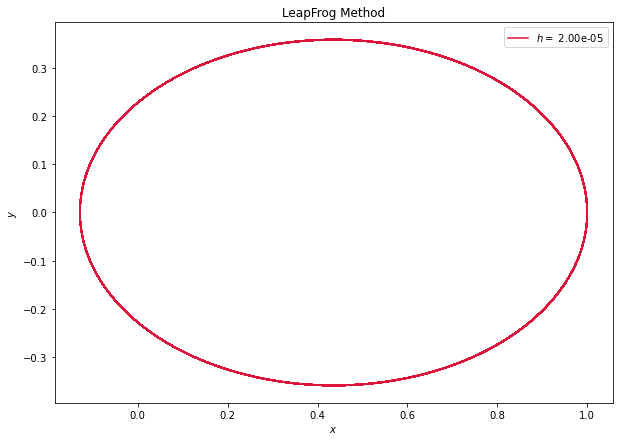

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(Q[:,0], Q[:,1], color='crimson', label=f'$h=$ {h:.2e}')
ax.set_title('LeapFrog Method')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()

plt.show()

Se puede notar que el método LeapFrog es mucho más rápido y más estable que el método de Euler.

---

Para comprobar el comportamiento de las cantidades conservadas con el método de LeapFrog, calcularemos la energía y el momento angular en cada paso,

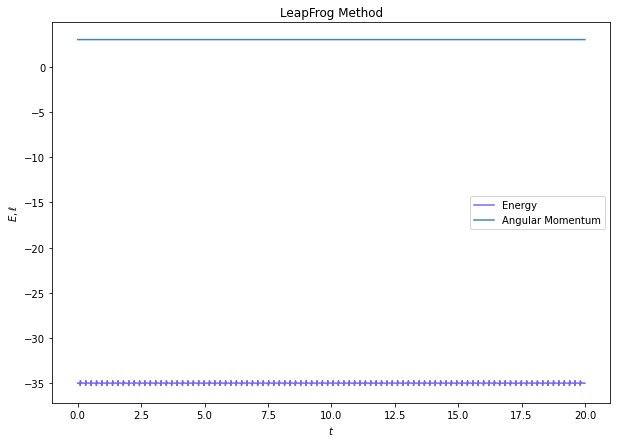

In [4]:
Energy = np.zeros(n)
AngMom = np.zeros(n)

for i in range(n):
    speed2 = Q[i,2]**2 + Q[i,3]**2
    r = np.sqrt(Q[i,0]**2 + Q[i,1]**2)
    Energy[i] = speed2/2 - G*M/r
    AngMom[i] = Q[i,0]*Q[i,3] - Q[i,1]*Q[i,2]


fig, ax = plt.subplots( figsize=(10,7))

ax.plot(t, Energy, color='mediumslateblue', label=f'Energy')
ax.plot(t, AngMom, color='steelblue', label=f'Angular Momentum')
ax.set_title('LeapFrog Method')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$E, \ell$')
ax.legend()

plt.show()

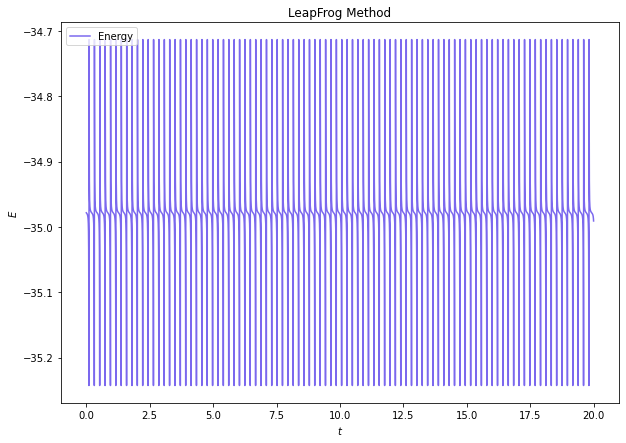

In [5]:
fig, ax = plt.subplots( figsize=(10,7))

ax.plot(t, Energy, color='mediumslateblue', label=f'Energy')
ax.set_title('LeapFrog Method')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$E$')
ax.legend()

plt.show()

Nótese que el promedio de estas cantidades es muy cercano al valor inicial,

In [6]:
Energy[0]

-34.97841729264834

In [7]:
Energy.mean()

-34.97840468380789

---
## Integrador Verlet 

Considere de nuevo el sistema de ODEs


\begin{equation}
\frac{d^2 x}{dt^2} = a(x)
\end{equation}

reescrito en la forma

\begin{align}
\begin{cases}
\frac{d x}{dt} = &v \\
\frac{d^2 x}{dt^2} = & \frac{dv}{dt} =  a(x(t)).
\end{cases}
\end{align}

Utilizaremos diferencias centradas para la primera y segunda derivada  para obtener las formulas iterativas

\begin{align}
\begin{cases}
\frac{x_{n+1} - x_{n-1}}{2h}  + \mathcal{O} (h^2) &= v_n \\
\frac{x_{n+1} - 2x_n + x_{n-1}}{h^2} + \mathcal{O} (h^2)  &= a(x_n).
\end{cases}
\end{align}

Re-acomodando estas ecuaciones da como resultado

\begin{align}
\begin{cases}
v_n &= \frac{x_{n+1} - x_{n-1}}{2h}  + \mathcal{O} (h^2) \\
x_{n+1} &= 2x_n - x_{n-1} + h^2 a(x_n) + \mathcal{O} (h^4) .  
\end{cases}
\end{align}

Este esquema se conoce como el método de **Verlet**. Nótese que, de nuevo, el método no es auto-iniciable debido a que se necesita los valores de $x_n$ y $x_{n-1}$ para obtener $x_{n+1}$. Además, es importante resaltar que este método puede obtener la evolución de la posición de forma independiente de los valores de la velocidad.

In [8]:
def Verlet(h, q0, s0):
    '''
    ------------------------------------------
    Verlet(h, q0, s0)
    ------------------------------------------
    Verlet method for solving a ODEs system.
    It needs to points to inizialize.
    ------------------------------------------
    Arguments:
    h: stepsize for the iteration
    q0: numpy array with the values of the
        coordinates in the n-step 
        q0[0] : x(n)
        q0[1] : y(n)
     s0: numpy array with the values of the
        coordinates in the (n-1)-step 
        s0[0] : x(n-1)
        s0[1] : y(n-1)
    ------------------------------------------
    Returns:
    Right hand side of the ODEs system as q1:
    q1[0] : x(n+1)
    q1[1] : y(n+1)
    q1[2] : vx(n)
    q1[3] : vy(n)
    ------------------------------------------
    '''
    ax, ay = ODE(q0)
    q1 = np.zeros(q0.shape)
    q1[0] = 2*q0[0] - s0[0] + ax*h**2
    q1[1] = 2*q0[1] - s0[1] + ay*h**2
    q1[2] = (q1[0] - s0[0])/(2*h)
    q1[3] = (q1[1] - s0[1])/(2*h)
    return q1



# Creation of the time grid (in years)
t_0 = 0.
t_f = 20.

# Number of steps in the grid
n = 1000000

# Constant stepsize defined by the number of steps in the grid
h = (t_f - t_0)/n

# Arrays to store the solution
t = np.linspace(t_0, t_f, n) # Time information
Q = np.zeros([n,4]) #  Motion information

# Initial Conditions
Q[0,0] = 1. # initial x
Q[0,1] = 0. # initial y
Q[0,2] = 0. # initial vx
Q[0,3] = 3. # initial vy

# Verlet algorithm needs to values of the coordinates to inizialize
# Therefore we take one backward Euler step to begin

S = np.zeros(2)

ax0, ay0 = ODE(Q[0])
S[0] = Q[0,0] - h*Q[0,2] + 0.5*ax0*h**2
S[1] = Q[0,1] - h*Q[0,3] + 0.5*ay0*h**2

Q[1,:] = Verlet(h, Q[0,:], S)

# Main loops for solving the problem

for i in range(2,n):
  Q[i,:] = Verlet(h, Q[i-1,:], Q[i-2,0:2])


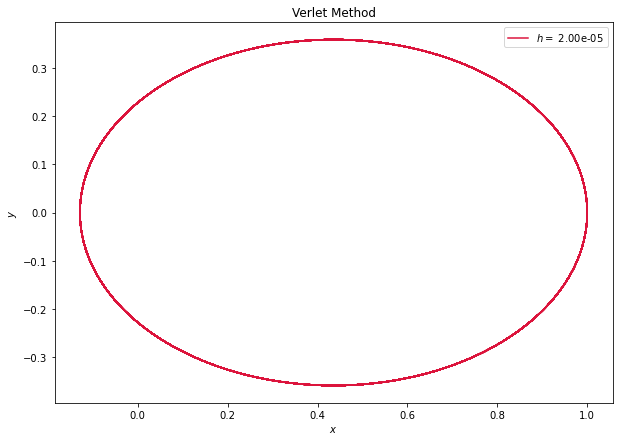

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(Q[:,0], Q[:,1], color='crimson', label=f'$h=$ {h:.2e}')
ax.set_title('Verlet Method')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()

plt.show()

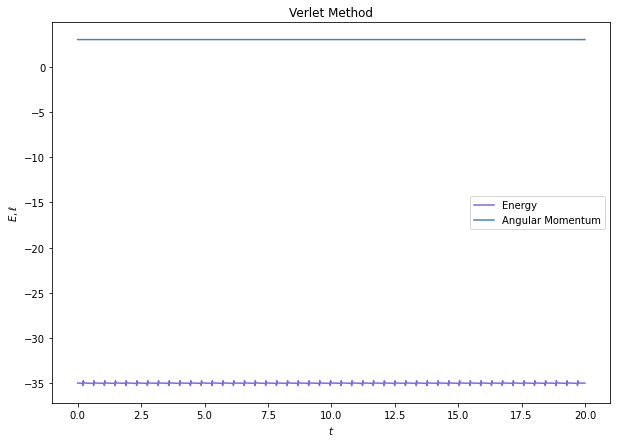

In [11]:
Energy = np.zeros(n)
AngMom = np.zeros(n)

for i in range(n):
    speed2 = Q[i,2]**2 + Q[i,3]**2
    r = np.sqrt(Q[i,0]**2 + Q[i,1]**2)
    Energy[i] = speed2/2 - G*M/r
    AngMom[i] = Q[i,0]*Q[i,3] - Q[i,1]*Q[i,2]


fig, ax = plt.subplots( figsize=(10,7))

ax.plot(t, Energy, color='mediumslateblue', label=f'Energy')
ax.plot(t, AngMom, color='steelblue', label=f'Angular Momentum')
ax.set_title('Verlet Method')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$E, \ell$')
ax.legend()

plt.show()

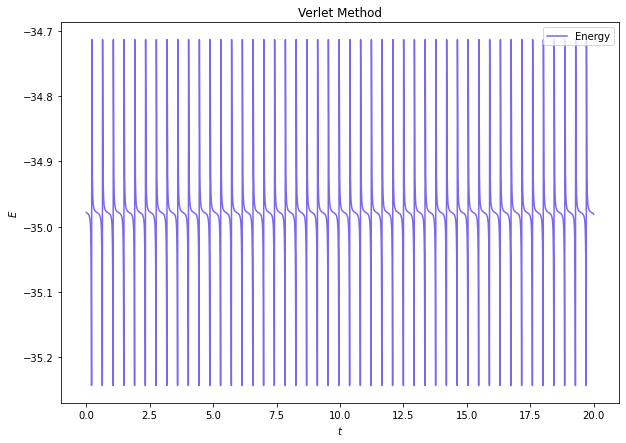

In [12]:
fig, ax = plt.subplots( figsize=(10,7))

ax.plot(t, Energy, color='mediumslateblue', label=f'Energy')
ax.set_title('Verlet Method')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$E$')
ax.legend()

plt.show()

In [13]:
Energy[0]

-34.97841760435743

In [14]:
Energy.mean()

-34.978424647533586